In [1]:
# connects colab to drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# importing nessecary libraries
import librosa
import librosa.display
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import *
from scipy.signal import kaiserord, lfilter, firwin, freqz, spectrogram

plt.rcParams['figure.figsize'] = [20,5]
# cqt bin frequencies
freq_cqt = librosa.cqt_frequencies(90, fmin=32)

In [0]:
# defining the class 
# each object of this class is an audio clip that is to be analysed
class Audio:
  def __init__(self, path, sr=None, duration = None):
    # loading the audio file
    self.x, self.sr1 = librosa.load(path= path, sr=sr,duration=duration)
    
    # bandpass filter with cutoff [110,500] to remove harmonics
    nyq_rate = self.sr1 / 2.0
    width = 5.0/nyq_rate
    N, beta = kaiserord(60.0, width)
    taps = firwin(N, [i/nyq_rate for i in [110.0, 500.0]], window=('kaiser', beta),pass_zero=False)
    self.x = lfilter(taps, 1.0, self.x)

    # getting the information of time from number of frames and number of samples
    self.time = librosa.samples_to_time(np.arange(0,len(librosa.frames_to_time(self.x,sr=self.sr1)),512))/2
    # calling necessary functions for processing
    self.spectrogram()
    self.pitch_contour()
    self.constant_pitch()

  #c omputer the spectrum of the audio file
  # uses cqt 
  def spectrogram(self,plot = False):
    cqt = librosa.cqt(self.x,sr=self.sr1)
    self.logC = librosa.amplitude_to_db(np.abs(cqt),ref = np.max)
    if plot:
      librosa.display.specshow(self.logC, sr=self.sr1, x_axis='time',y_axis = 'cqt_hz')
  """
  def spectrogram(self,plot = False):
    stft = librosa.stft(self.x)
    S, phase = librosa.magphase(stft)
    self.logC = librosa.amplitude_to_db(S,ref = np.max)
    if plot:
      librosa.display.specshow(self.logC, sr=self.sr1, x_axis='time',y_axis = 'log')
  """

  # lowpass filter for the frequencies
  def low_pass_digital(self,S, dt = 70, ts = 50): # parameters have to be verified
    low = []
    alpha = dt/(int(dt)+ts)
    low.append((1-alpha)*S[0])
    for i in range(1,len(S)):
      g = (1-alpha)*S[i] + alpha*low[i-1]
      low.append(g)
    return low

  # computing pitch contour
  def pitch_contour(self):
    pitch = []
    i,j = self.logC.shape
    step = np.ones(j)
    
    # checking the maximum power component along the coloumn of the spectogram 
    # and storing the index of the same which is then mapped into its corresponding frequencies
    for k in range(0,j):
      temp = np.where(self.logC[:,k]==np.amax(self.logC[:,k]))
      pitch.append(temp[0][0])
      # removing spectral cavity
      if np.amax(self.logC[:,k]) < -15:  
        step[k] = np.nan
   
    pitch = [ freq_cqt[i] for i in pitch]
    pitch = self.low_pass_digital(pitch)
    self.pitch = [a*b for a,b in zip(pitch,step)]
  #
  def constant_pitch(self):
    # normalised pitch by 12*log(to the base 2) (f[i]/f0)
    # where f0 is the tonic 
    self.normalised_pitch=[]
    for i in self.pitch:
      self.normalised_pitch.append((12*np.log2(i/191.782)))
    
    # calculating the 1st order difference
    self.diff_n = np.diff(self.normalised_pitch)
    
    k=[]
    for i in range(len(self.diff_n)):
      # constant note when the slope(of the pitch contour) is within the thershold i.e, delta =  
      if(self.diff_n[i]<0.01 and self.diff_n[i]>-0.01):
        k.append((self.normalised_pitch[i],self.time[i]))
    k = np.array(k)
    self.constant_pitch_notes,self.constant_pitch_time = k.T
  

In [0]:
shankarabarana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Raga_Surabhi_3.wav')

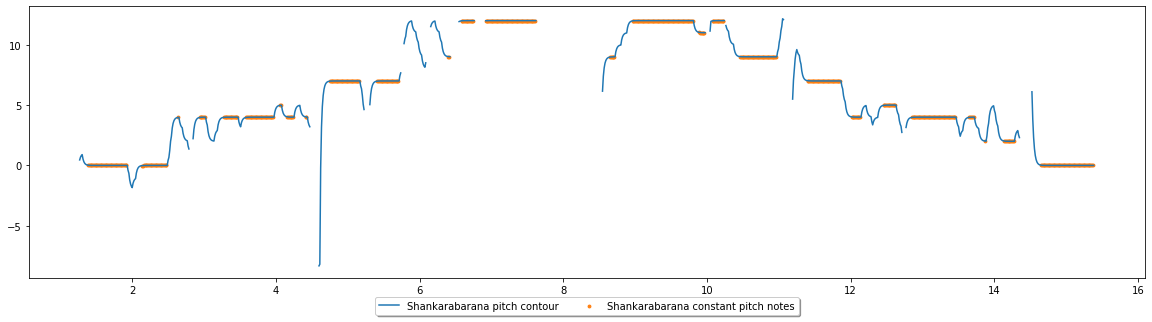

In [72]:
fig, ax = plt.subplots()
ax.plot(shankarabarana.time,shankarabarana.normalised_pitch,label = 'Shankarabarana pitch contour')
ax.scatter(shankarabarana.constant_pitch_time,shankarabarana.constant_pitch_notes,s=8,c = '#ff7f0e',label = 'Shankarabarana constant pitch notes')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()

In [0]:
kalyani_0 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_0.wav')

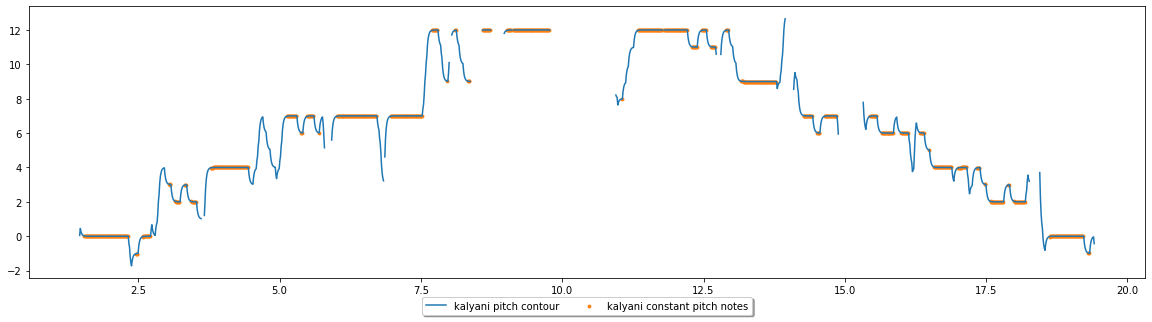

In [71]:
fig, ax = plt.subplots()
ax.plot(kalyani_0.time,kalyani_0.normalised_pitch,label = 'kalyani pitch contour')
ax.scatter(kalyani_0.constant_pitch_time,kalyani_0.constant_pitch_notes,s=8,c = '#ff7f0e',label = 'kalyani constant pitch notes')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()